In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# CFSv2

In [2]:
#Forecasts
cfsv2_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.MONTHLY/.sst/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y/M%5Daverage/dods'
#Verification time
T_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.MONTHLY/.T/dods'
#Observations NOT subsetted to match
obs_url = "http://iridl.ldeo.columbia.edu/expert/SOURCES/.NOAA/.NCEP/.EMC/.CMB/.GLOBAL/.Reyn_SmithOIv2/.monthly/.sst/T/(1%20Jan%201980)/(1%20Dec%202012)/RANGE/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y%5Daverage/dods"

In [3]:
obs_ds = xr.open_dataset(obs_url,decode_times=False)
o = obs_ds.sst
cfsv2_ds = xr.open_dataset(cfsv2_url,decode_times=False)
T_ds = xr.open_dataset(T_url,decode_times=False)
V = T_ds.T

In [4]:
cfsv2_ds["o"] = (( "L", "S"), o.sel(T=V))
cfsv2_ds

<xarray.Dataset>
Dimensions:  (L: 10, S: 348)
Coordinates:
  * S        (S) float32 264.0 265.0 266.0 267.0 ... 608.0 609.0 610.0 611.0
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
Data variables:
    sst      (S, L) float64 ...
    o        (L, S) float64 26.72 26.7 27.2 28.02 ... 27.46 26.96 26.19 25.98
Attributes:
    Conventions:  IRIDL

In [5]:
def decode_cf(ds, time_var):
    if ds[time_var].attrs['calendar'] == '360':
        ds[time_var].attrs['calendar'] = '360_day'
    ds = xr.decode_cf(ds, decode_times=True)
    return ds

In [6]:
cfsv2_decoded_ds = decode_cf(cfsv2_ds,"S")
f = cfsv2_decoded_ds.sst
o = cfsv2_decoded_ds.o

In [7]:
fa = f.groupby("S.month") - f.groupby("S.month").mean("S")
oa = o.groupby("S.month") - o.groupby("S.month").mean("S")

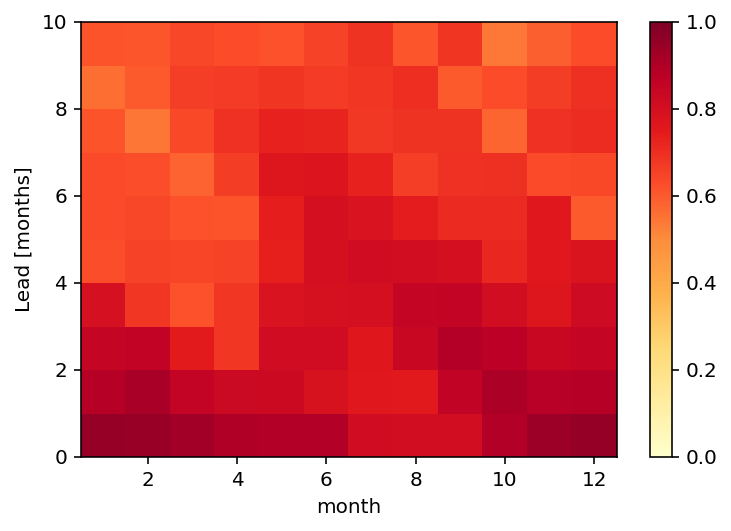

In [8]:
# Compute anomaly correlation as function of start and lead using groupby
ac = (fa*oa).groupby("S.month").mean("S")/fa.groupby("S.month").std("S")/o.groupby("S.month").std("S")
ac.plot(x="month",y="L",cmap=plt.cm.YlOrRd,vmin=0.0,vmax=1.0);

TypeError: float() argument must be a string or a number, not 'cftime._cftime.Datetime360Day'

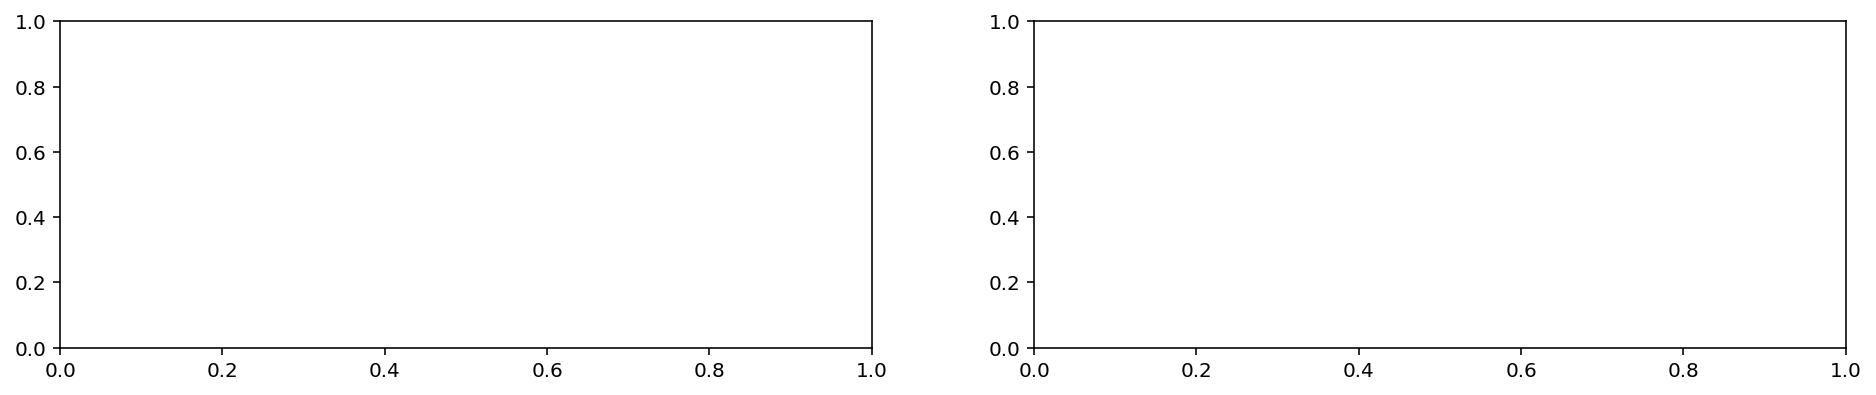

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16,3))
fa.plot(ax=axs[0])
axs[0].set_title("Forecast anomaly")
oa.plot(ax=axs[1],x="S",y="L")
axs[1].set_title("Observed anomaly");

# CCSM4 using indices rather than times. Potential for error

In [ ]:
f_ds = xr.open_dataset("https://iridl.ldeo.columbia.edu/expert/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.sst/S/(1%20Jan%201982)/(1%20Dec%202010)/RANGE/L/0.5/11.5/RANGE/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/%5BX/Y/M%5Daverage/S/(days%20since%201960-01-01)streamgridunitconvert/dods")
f = f_ds.sst
o_ds = xr.open_dataset("http://iridl.ldeo.columbia.edu/expert/SOURCES/.NOAA/.NCEP/.EMC/.CMB/.GLOBAL/.Reyn_SmithOIv2/.monthly/.sst/T/(1%20Jan%201982)/(1%20Dec%202011)/RANGE/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y%5Daverage/T/(days%20since%201960-01-01)streamgridunitconvert/dods")
o1d = o_ds.sst

In [ ]:
nleads = f_ds.L.size
nstarts = f_ds.S.size

# T = S + L (indices NOT times)
T = (np.arange(0,nleads).reshape(1,nleads) + np.arange(0,nstarts).reshape(nstarts,1)).astype(int)
T.shape

In [ ]:
o2d = o1d.values[T] # "sample-along" 

f_ds["o"] = (("S", "L"), o2d)
o = f_ds.o 
o

In [ ]:
O2D_ds = xr.open_dataset("http://iridl.ldeo.columbia.edu/expert/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.sst/S/(1%20Jan%201982)/(1%20Dec%202010)/RANGE/L/0.5/11.5/RANGE/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/%5BX/Y/M%5Daverage/SOURCES/.NOAA/.NCEP/.EMC/.CMB/.GLOBAL/.Reyn_SmithOIv2/.monthly/.sst/S/L/add/T/sample-along/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/%5BX/Y%5Daverage/S/(days%20since%201960-01-01)streamgridunitconvert/dods")
O2D_ds.sst - f_ds.o

In [ ]:
fa = f.groupby("S.month") - f.groupby("S.month").mean("S")
oa = o.groupby("S.month") - o.groupby("S.month").mean("S")
fig, axs = plt.subplots(1, 2, figsize=(16,3))
fa.plot(ax=axs[0],x="S",y="L")
axs[0].set_title("Forecast anomaly")
oa.plot(ax=axs[1],x="S",y="L")
axs[1].set_title("Observed anomaly");

In [ ]:
# Compute anomaly correlation as function of start and lead using groupby
ac = (fa*oa).groupby("S.month").mean("S")/fa.groupby("S.month").std("S")/o.groupby("S.month").std("S")
ac.plot(x="month",y="L",vmax=1,vmin=0);

In [ ]:
# Compute anomaly correlation as function of start and lead using loops
AC = np.zeros((12,nleads))+np.nan
for im in range(0,12):
    for il in range(0,nleads):
        x = f[im::12,il]
        y = o2d[im::12,il]
        AC[im,il] = np.corrcoef(x,y)[0,1]
plt.pcolormesh(AC.transpose(),vmax=1,vmin=0)
plt.xlabel('start month')
plt.ylabel('lead')
plt.colorbar();

Computed in the DL

![image](http://iridl.ldeo.columbia.edu/expert/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.sst/S/%281%20Jan%201982%29/%281%20Dec%202010%29/RANGE/L/0.5/11.5/RANGE/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/%5BX/Y/M%5Daverage/SOURCES/.NOAA/.NCEP/.EMC/.CMB/.GLOBAL/.Reyn_SmithOIv2/.monthly/.sst/S/L/add/T/sample-along/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/%5BX/Y%5Daverage/%5BL/S%5DREORDER/S/12/splitstreamgrid/exch/S/12/splitstreamgrid/%5BS2%5D/correlate/S+L+fig-+colors+-fig+//correlation/0/1/plotrange+//XOVY+null+psdef//plotaxislength+432+psdef//plotborder+72+psdef+.gif)

In [ ]:
plt.pcolormesh(f)

In [ ]:
# Compute anomaly correlation as function of start and lead using loops
AC = np.zeros((12,nleads))+np.nan
for im in range(0,12):
    for il in range(0,nleads):
        x = f[im::12,il]
        y = o2d[im::12,il]
        AC[im,il] = np.corrcoef(x,y)[0,1]
plt.pcolormesh(AC.transpose(),vmax=1,vmin=0)
plt.xlabel('start month')
plt.ylabel('lead')
plt.colorbar();